In [3]:
import sys
import os

import pandas as pd
import scanpy as sc
import numpy as np
import warnings

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import anndata
import seaborn as sns
import matplotlib.font_manager
from matplotlib import rcParams

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'
rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Replace 'path_to_dataset' with the actual file paths
adata = sc.read_h5ad('../squidward_study/public_01/pub_all_data.h5ad')
adata = adata[adata.obs['patient']=='PW030']

adata.var['mt'] = np.logical_or(
        adata.var_names.str.startswith('MT-'),
        adata.var_names.str.startswith('mt-')
)
adata.var['rb'] = (
    adata.var_names.str.startswith('RP-') |
    adata.var_names.str.startswith('rp-')
)

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

mask_cell = adata.obs['pct_counts_mt'] < 95
mask_gene = np.logical_and(~adata.var['mt'], ~adata.var['rb'])

adata = adata[mask_cell, mask_gene]
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=250)

In [7]:
marker_gene_list = ['CD14', 'AIF1', 'TYROBP', 'CD163', #myeloid cells
                    'PLP1', 'MBP', 'MAG', 'SOX10', #oligodendrocytes
                    'CD44','VIM',#mesenchymal like tumor
                    'GFAP',#astrocytic subpopulatio
                    'TOP2A','MKI67',#proliferating
]

for gene_ in marker_gene_list:
    adata.var['highly_variable'][gene_]=True
    
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.leiden(adata,resolution=0.5)
sc.tl.umap(adata,min_dist=0.5)

In [8]:
adata.obs['cell_type'] = adata.obs['leiden'].map({'0':'Tumor cells',
                                                  '1':'Myeloid cells',
                                                  '2':'Tumor cells',
                                                  '3':'Oligodendrocytes',
                                                  '4':'Tumor cells',
                                                  '5':'Tumor cells',
                                                  '6':'Myeloid cells',
                                                  '7':'Tumor cells',
    
})

(-2.4780937314033507,
 14.796064722537995,
 -3.9297359704971315,
 11.166212391853332)

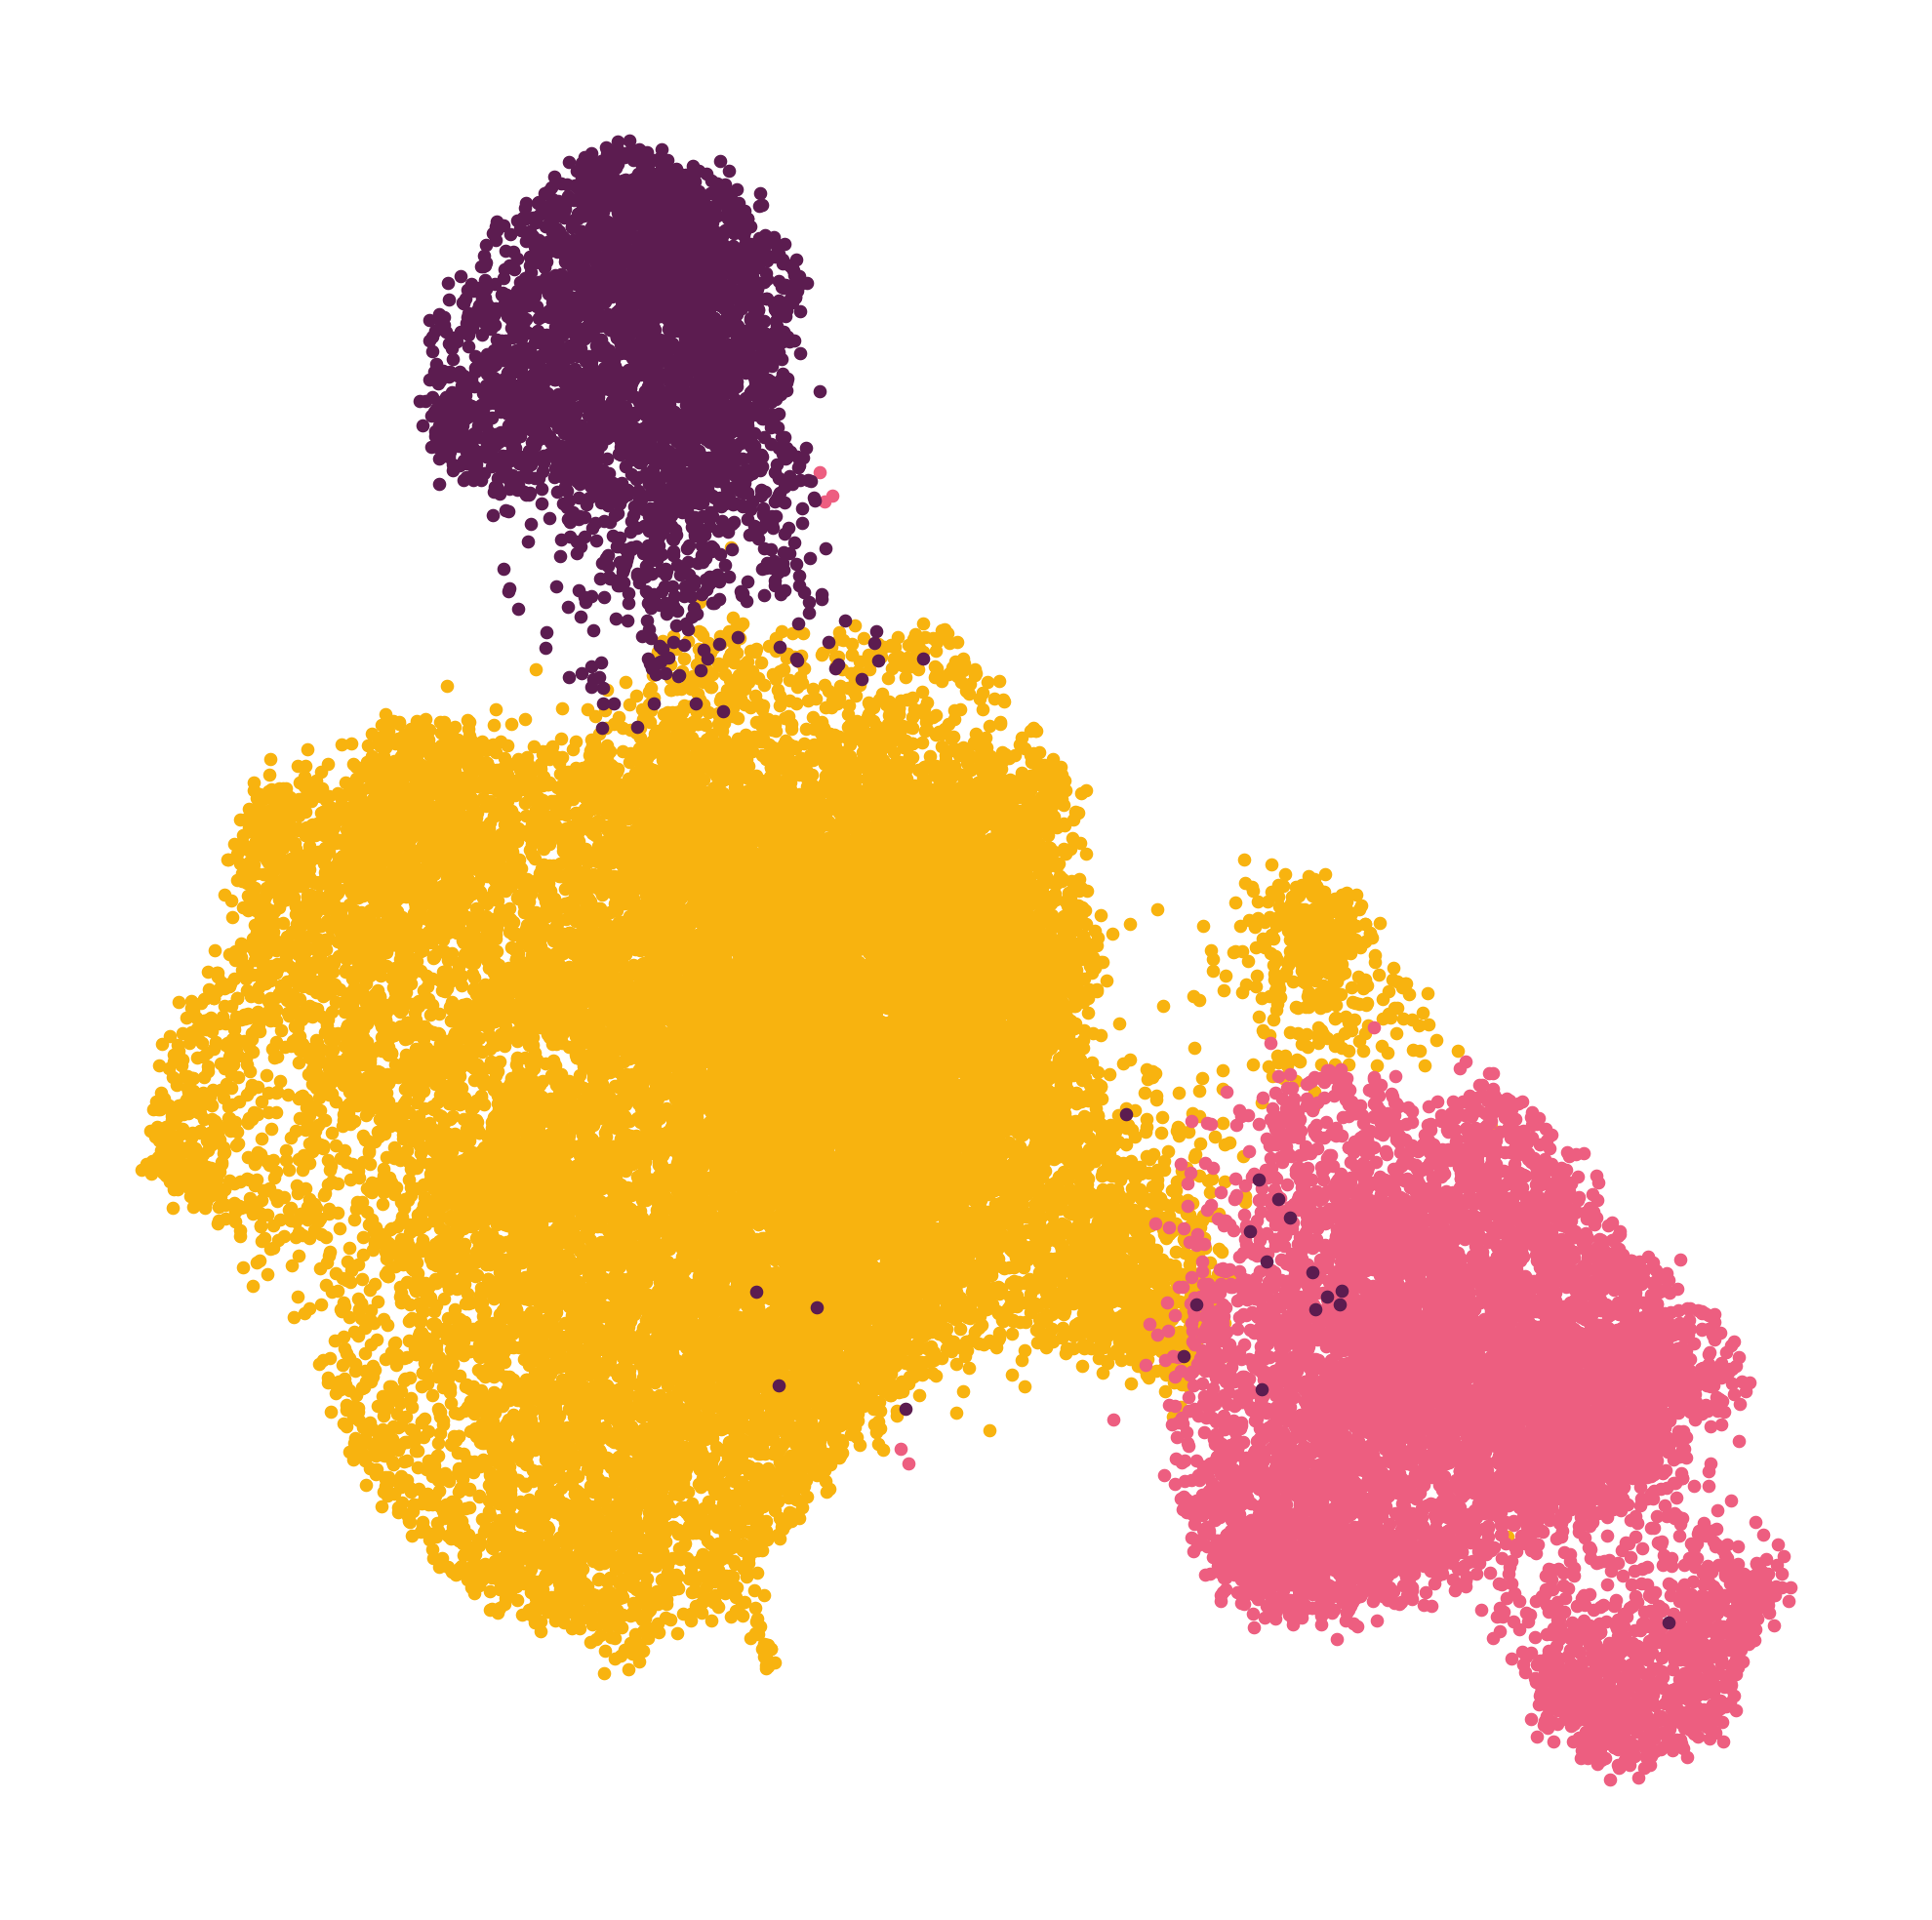

In [9]:
colors = ['#f8b30f','#ed5e80','#5C1C50',]
#colors = ['#ed5e80','#ed5e80','#ed5e80','#ed5e80','#ed5e80','#ed5e80','#5C1C50',]
plt.subplots(1,1,figsize=(4,4),dpi=600)
for j,i in enumerate(adata.obs['cell_type'].unique()):
    plt.scatter(adata.obsm['X_umap'][adata.obs['cell_type']==i,0],
                adata.obsm['X_umap'][adata.obs['cell_type']==i,1],
                c=colors[j],
                #c=adata.to_df().loc[:,'PLP1'],
                s=0.4
                )
#plt.legend(adata.obs['cell_type'].unique())
plt.axis('off')

(-2.4780937314033507,
 14.796064722537995,
 -3.9297359704971315,
 11.166212391853332)

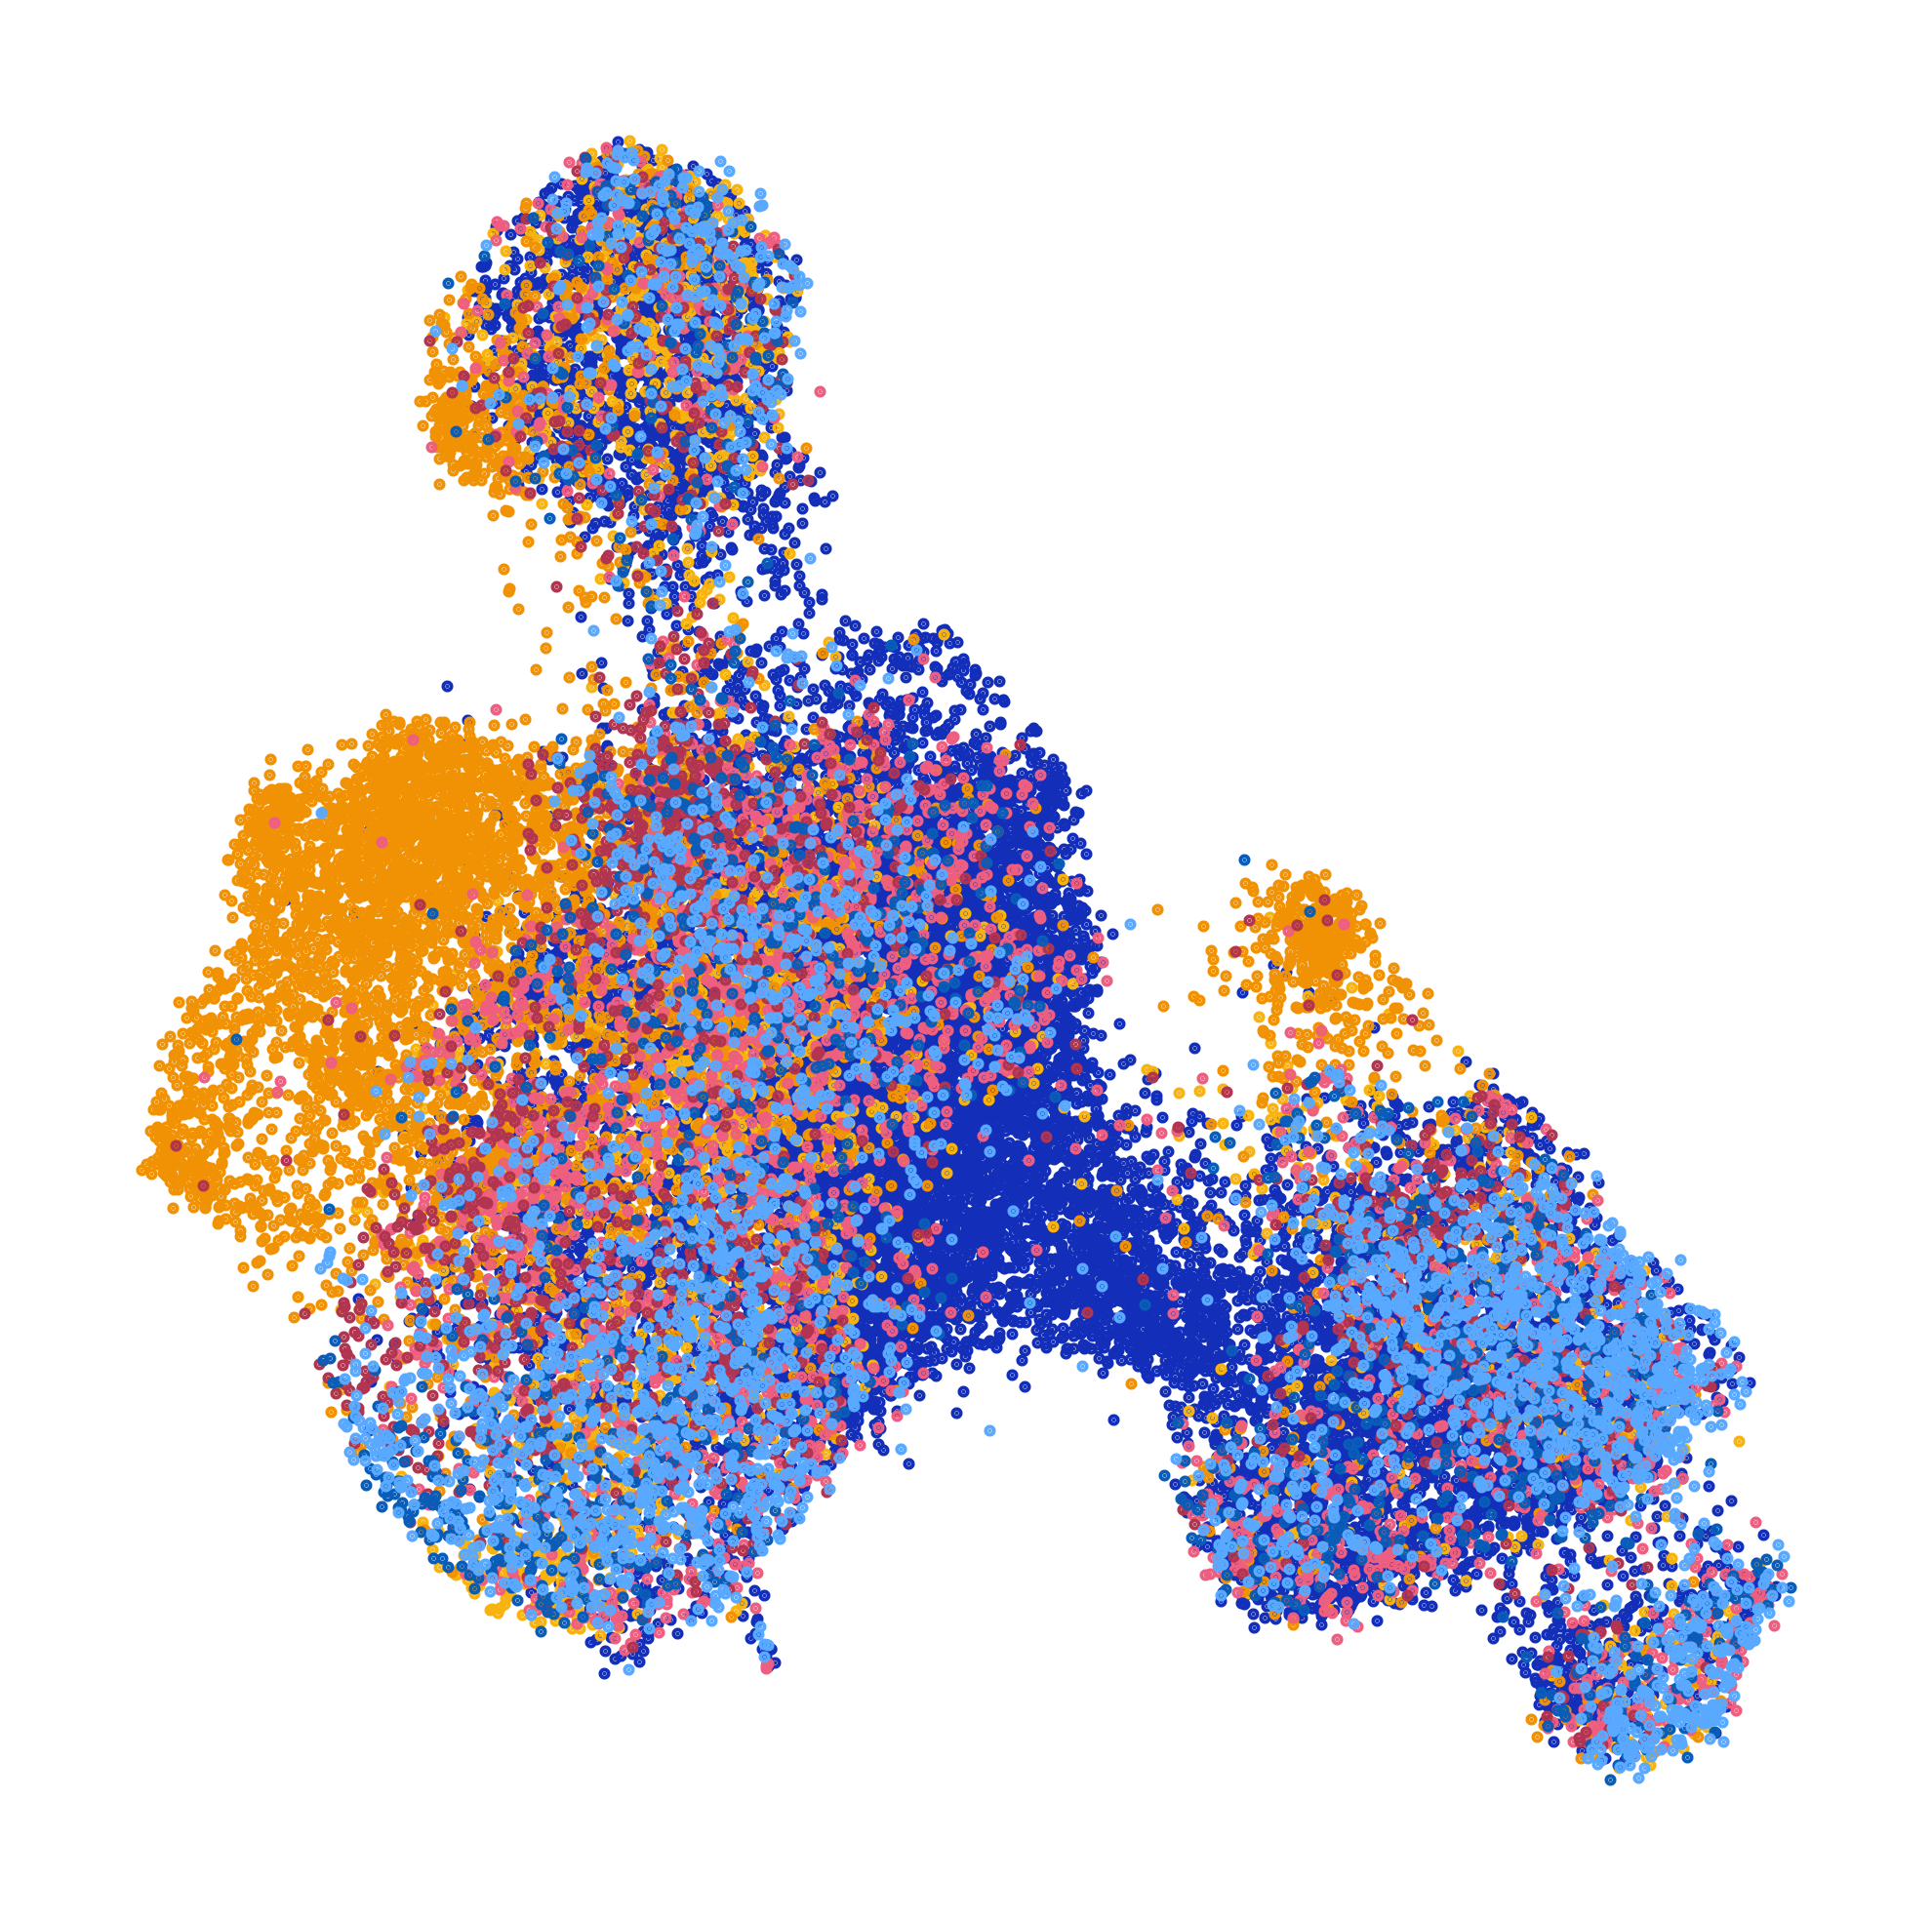

In [10]:
colors = ['#132fba','#f8b30f','#f09204','#ed5e80','#b13450','#095db8','#58a9ff']
#colors = ['#ed5e80','#ed5e80','#ed5e80','#ed5e80','#ed5e80','#ed5e80','#5C1C50',]
plt.subplots(1,1,figsize=(4,4),dpi=600)
for j,i in enumerate(adata.obs['condition'].unique()):
    plt.scatter(adata.obsm['X_umap'][adata.obs['condition']==i,0],
                adata.obsm['X_umap'][adata.obs['condition']==i,1],
                c=colors[j],
                #c=adata.to_df().loc[:,'PLP1'],
                s=0.2,
                alpha=1
                )

plt.axis('off')

In [11]:
adata = sc.read_h5ad('../squidward_study/public_01/pub_all_data_fig.h5ad')

In [12]:
adata.obs.condition

TCGTGCATCAGGPW030-701    vehicle
TGTGGCACGAATPW030-701    vehicle
TGGGTTCGAAGCPW030-701    vehicle
ATCCCTTACACGPW030-701    vehicle
GCGATCTTTTCAPW030-701    vehicle
                          ...   
ACTGATAGTCTCPW030-708     Ana-12
CATACTTGGTCTPW030-708     Ana-12
GCTTCGGACGGGPW030-708     Ana-12
GCTAGGCTACTCPW030-708     Ana-12
AATCTACTGTGCPW030-708     Ana-12
Name: condition, Length: 34141, dtype: category
Categories (7, object): ['Ana-12', 'Ispenisib', 'RO4929097', 'Tazemetostat', 'etoposide', 'panobinostat', 'vehicle']

In [ ]:
adata1 = adata[adata.obs['condition'].isin(['vehicle','etoposide'])].copy()
import random
total_cells = adata1.shape[0] 
all_indices = list(range(total_cells))
selected_indices = random.sample(all_indices, 5000)

adata1 = adata1[selected_indices]

adata2 = adata[adata.obs['condition'].isin(['panobinostat','RO4929097','Tazemetostat','Ispenisib','Ana-12'])].copy()

total_cells = adata2.shape[0] 
all_indices = list(range(total_cells))
selected_indices = random.sample(all_indices, 3000)
adata2 = adata2[selected_indices]
adata2_sub = adata2[adata2.obs['cell_type'].isin(['Myeloid cells'])].copy()

trained_adata = sc.concat([adata1, adata2_sub])